In [79]:
import pandas as pd
import glob
import os
import pdb
# use your path
all_files = glob.glob('/home/p/pbryant/pfs/results/CATH/20190605/*/*.tsv')     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(f, sep='\t') for f in all_files]
for dataframe, filename in zip(df_from_each_file, all_files):
    dataframe['H_group'] = filename.split('/')[-2]
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)


Slope:  0.469056262941
Intercept:  1.22439354254


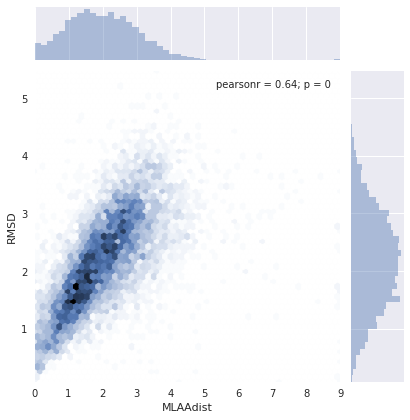

In [93]:
#Filter: concatenated_df[concatenated_df['MLAAdist']<6]

from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
#Calculate line of best fit
ML_dists = concatenated_df['MLAAdist']
rmsd_dists = concatenated_df['RMSD']
(slope, intercept, r_value, p_value, std_err) = stats.linregress(ML_dists, rmsd_dists)
print('Slope: ', slope)
print('Intercept: ', intercept)

#Get deviations from line of best fit
deviations = [] #Save deviations
for i in range(0, len(ML_dists)):
    deviation = rmsd_dists[i]-(intercept+slope*ML_dists[i])
    deviations.append(deviation)

concatenated_df['deviation'] = deviations
#Plot RMSD and ML_dist
sns.jointplot(x="MLAAdist", y="RMSD", data=concatenated_df, kind = "hex")
plt.show()

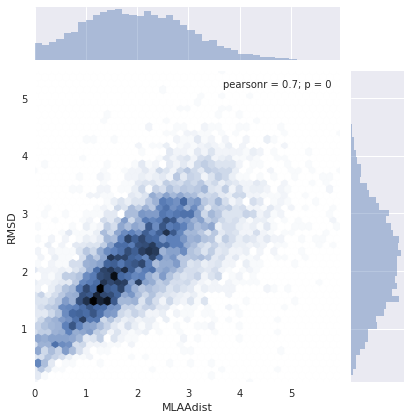

In [97]:
sns.jointplot(x="MLAAdist", y="RMSD", data=concatenated_df[concatenated_df['MLAAdist']<6], kind = "hex")
plt.show()

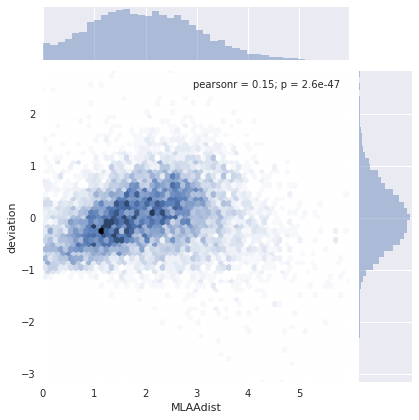

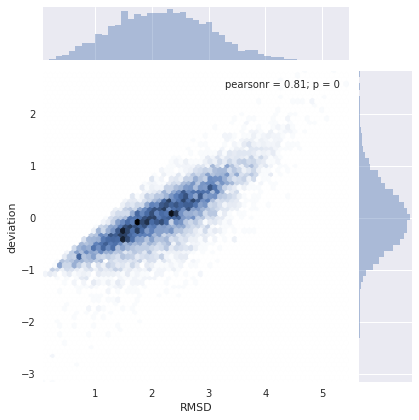

In [101]:
sns.jointplot(x="MLAAdist", y="deviation", data=concatenated_df[concatenated_df['MLAAdist']<6], kind = "hex")
plt.show()
sns.jointplot(x="RMSD", y="deviation", data=concatenated_df[concatenated_df['MLAAdist']<6], kind = "hex")
plt.show()

In [7]:
#Functions
def read_tsv(H_groups_file):
	'''Read ids and H-groups into dict
	'''

	H_groups = {} #Store H-groups and uids

	with open(H_groups_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			line = line.split(',')
			uid = line[0]
			H_group = line[1:]
			H_group = H_group[0]+'.'+H_group[1]+'.'+H_group[2]+'.'+H_group[3]
			H_groups[uid] = H_group


	return H_groups

def read_fasta(fasta_file):
	'''Read fasta file into dict
	'''

	sequences = {} #Store sequences

	with open(fasta_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			if line[0] == '>':
				uid = line.split('|')[2].split('/')[0]
			else:
				sequences[uid] = line

	return sequences


def get_groups(H_groups, sequences):
	'''Get H-group for each uid and group sequences accordingly
	'''


	grouped_sequences = {} #Sequences grouped by H-group

	for key in sequences:
		H_group = H_groups[key]
		sequence = sequences[key]

		if H_group not in grouped_sequences.keys(): #If not in new dict - add
			grouped_sequences[H_group] = [key + '/' + sequence]
		else:
			grouped_sequences[H_group].append(key + '/' + sequence) #Otherwise append

	return grouped_sequences



H_groups = read_tsv('/home/pbryant/data/CATH/h_grouped/H_group.tsv')
sequences = read_fasta('/home/pbryant/data/CATH/cath-domain-seqs-S95.fa')
grouped_sequences = get_groups(H_groups, sequences)

In [26]:
num_entries = []
under_x = []
x = 15
for key in grouped_sequences:
    num_entries.append(len(grouped_sequences[key]))
    if len(grouped_sequences[key]) < x:
        under_x.append(len(grouped_sequences[key]))

Text(0.5, 1.0, 'Average: 9.51\nTotal number of entries: 6119')

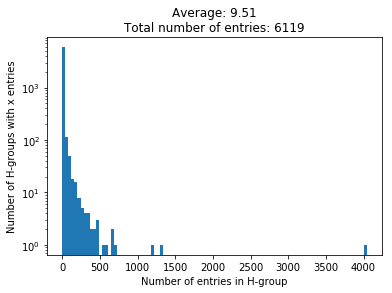

In [34]:
import matplotlib.pyplot as plt
plt.hist(num_entries, bins = 100, log = True)
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
average = sum(num_entries)/len(num_entries)
plt.title('Average: '+str(round(average, 2)) + '\n'+ 'Total number of entries: ' + str(len(num_entries)))

Text(0.5, 1.0, 'Average: 2.68\nTotal number of entries: 5553')

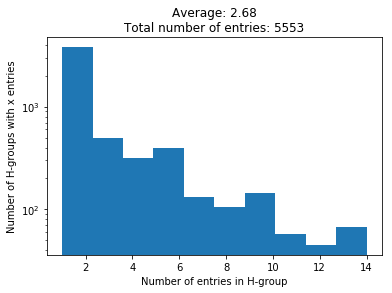

In [36]:
plt.hist(under_x, bins = 10, log = True)
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
average = sum(under_x)/len(under_x)
plt.title('Average: '+str(round(average, 2)) + '\n' +'Total number of entries: ' + str(len(under_x)))


ML_dists: 13742
rmsd_dists 13742


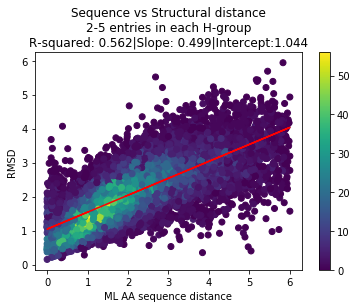

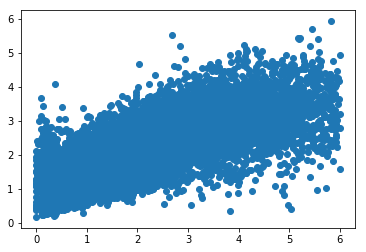

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from plot_dist import read_tsv
#Look here https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

dist_file = '/home/pbryant/results/CATH/20190430/all_dist_rmsd.tsv'
(ML_dists, rmsd_dists, Z) = read_tsv('/home/pbryant/results/CATH/20190430/all_dist_rmsd.tsv', 6)
print('ML_dists:',len(ML_dists))
print('rmsd_dists',len(rmsd_dists))

#100 since 2 decimals?
#E.g. 10*9 in z, means 90 bins --> can differ max 0.1 to be in the same bin (accuracy = 0.01)
xedges, yedges = np.linspace(0, 9, 10*9), np.linspace(0, 8, 10*8)
hist, xedges, yedges = np.histogram2d(ML_dists, rmsd_dists, (xedges, yedges))

xidx = np.clip(np.digitize(ML_dists, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(rmsd_dists, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
plt.scatter(ML_dists, rmsd_dists, c=c)

#Calculate line of best fit
(slope, intercept, r_value, p_value, std_err) = stats.linregress(ML_dists, rmsd_dists)

#Desciption
plt.title('Sequence vs Structural distance' + '\n' + '2-5 entries in each H-group'+ '\n' +'R-squared: ' + str((r_value**2).round(3)) +'|' + 'Slope: ' + str(slope.round(3)) + '|Intercept:'+ str(intercept.round(3)))
plt.xlabel('ML AA sequence distance')
plt.ylabel('RMSD')
#Line of best fit
plt.plot(ML_dists, intercept + slope*np.array(ML_dists), 'r')
#Colorbar
plt.colorbar()

plt.show()

plt.scatter(ML_dists, rmsd_dists)

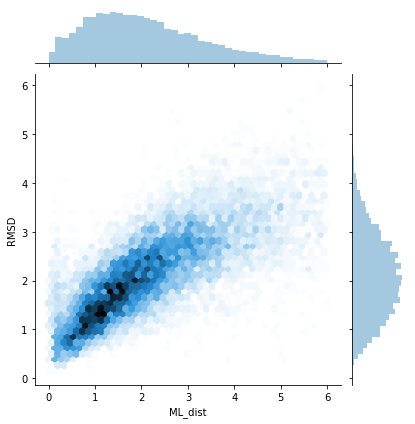

In [143]:
df = pd.DataFrame(list(zip(ML_dists, rmsd_dists)), 
               columns =['ML_dist', 'RMSD']) 

sns.jointplot(x="ML_dist", y="RMSD", data=df, kind = "hex")

In [16]:
#Get deviations from line of best fit
deviations = [] #Save deviations
for i in range(0, len(ML_dists)):
    deviation = rmsd_dists[i]-(intercept+slope*ML_dists[i])
    print(deviation)
    deviations.append(deviation)
    

-0.012221662034789915
0.4123035151444925
-0.05750655572722052
0.6826019752032293
-0.3978321485185695
-0.24723522840109613
0.08219498421404281
-0.26739802479677066
-0.26262865302397653
0.662574842470617
0.881950789620531
0.5127105061336792
1.0024934442727798
0.000518743959065926
-0.40321958397445634
-0.024250627813728443
0.754664062881774
0.23621062864068243
0.5399760893068168
0.20016601843510395
-0.11425062781372874
0.6458579031167213
1.8247183283469983
-0.639562654238772
-1.140940434435012
0.15940630192195604
-0.3749018133964275
-0.6541963623485039
0.32555944305798423
0.39875511633925775
-0.07465761880291533
-0.07612278636398662
-0.4396711851692219
0.8790807091306068
-0.4945490878724659
0.028782249071870103
-0.5654444680486759
-0.7488843359234614
0.8486194526761954
0.774148540962138
0.22292756799457858
-0.47674683921407235
-0.10059369807804419
-0.2712448836607424
0.05368728450772653
-1.0312660272263616
-0.08143481278902942
-0.1525412656591456
-0.06075649447371889
0.05222211694665524
0

-0.36230306023262737
-0.4681577413099187
-0.11322557314144976
-0.5470724320054214
0.018782249071870094
0.27880938180448256
0.07374154997295124
-0.126909635609747
0.06284616979674107
0.1374256124412485
0.13214071874881794
-0.23612278636398654
-0.10186893651082829
0.18742561244124856
-0.6476693521228951
-0.5982120067751436
-0.5609946999002373
-0.3771749737688781
-0.7026557857565887
-0.502547254826139
-0.01232420379824628
-0.7861227863639866
0.34878224907187017
-0.02701816654019651
0.6041485409621381
0.5103830802960032
0.3892977709915062
0.6543927355556498
0.7450167884057359
0.44087146948302713
0.3248268592774486
-0.12571579537479982
-0.5206750962758813
0.07951483285240579
-0.003035644013162919
0.039189240061056285
0.1188636472697071
-0.7732798386066747
-0.8875336884598328
-0.9274522902619955
-0.8377507503207322
-0.843035644013163
-0.7773980247967707
-0.8026557857565887
-0.7173708920641582
-0.7973708920641582
-0.1799425124953462
-0.2948475479312025
-0.24682823741190973
0.3493520364567311


-0.16254725482613908
-0.1278321485185696
-0.46365370769625525
0.08209244245058667
0.06509818660357292
0.09452839921871181
0.21428420462520004
-0.004196362348503513
-0.37810347584469384
0.5655865757905967
0.026454823234194347
0.4357493721862715
-0.9741692296158917
-0.8311634854629051
-0.5999696452279581
0.02916210732844382
-0.7148475479312024
-0.8601053088910204
-0.5002138398214697
-1.1843048932789535
-0.8655258662465131
-0.6364212464227235
-0.08644837915533565
0.114419868288262
0.24539664666230943
0.8638500809034011
1.0428461697967413
0.17379581543817624
-0.035254538920388434
0.4251524520687977
0.9686194526761955
-0.3962313172944363
-0.13552586624651308
0.1892435055262811
-0.027609097490676415
-0.5862584500270487
-0.15696390107497193
-0.17132628185857968
-0.026746839214072393
0.44157093136395686
0.8265030995324258
-0.05790755754941346
0.6588365145370949
0.7487279836066452
0.4529818334598035
0.24295470072719105
0.4491078418632193
0.45165232956179424
-0.0771266974706466
-0.29425062781372

0.46861945267619554
0.45474546107961134
-0.40289399118310687
-0.31907426505174774
-0.41836881400382486
0.03794113436088464
-0.211977467441278
-0.13821200677514356
0.15254770973800458
0.3279411343608847
-0.2382934049729809
0.00785973616304747
-0.2566111755510101
0.03279190433151635
0.028239594419621206
-0.047479422994608056
0.7194063019219561
0.85439273555565
-0.08652977735317302
-0.4781848740425312
-0.43753368845983287
-0.02677397194668485
-0.45257438755875157
-0.09192320197605297
-0.1618418037782159
-0.3582934049729809
-0.15677397194668474
-0.11652977735317305
-0.573117042211
-0.0723844584304647
-0.3273980247967707
-0.4172623611337085
-0.6021945293021775
0.007371346976023485
0.007615541569535367
-0.22257438755875159
-0.04186893651082846
-0.6923844584304646
0.16769693976737265
0.1425205770053921
0.31333455898376483
0.4475884088369231
0.58788686889566
0.6480225325587221
-0.03777788305334462
0.2778597361630475
0.49079007128518937
0.7342842046252
0.24211358601620558
0.7748268592774488
0.6

0.5135244881120518
-0.8006691071088876
0.6053152484644722
-0.6977990266189638
0.1911970622743766
-1.1525141329265334
0.31542377939492194
-0.6101053088910204
0.03515245206879758
-0.1599425124953462
0.007832603430435015
0.05726281604557393
0.18753414337169816
0.10796826709349716
0.22728994877818653
-0.09243872389568941
-0.19262865302397647
-0.012465856628301797
0.07265624066845433
-0.15214026383695267
0.1415437986313446
1.1182184508540023
0.3924663115401672
0.4825748424706169
0.9825477097380046
0.7922221169466555
1.0576426743021479
0.982716495300672
1.2678385925974283
0.3973170815107987
1.1680013889931025
0.4910885313439266
-0.10273718395442599
0.002194984214042961
-0.41818487404253113
0.5458307703841085
-0.3176422193902826
-0.22815774130991873
0.9952067175340225
0.9549896556731228
-0.1428185821522634
-0.1263127154922734
0.21823959441962115
-0.6758514590378621
0.15851691091273912
0.956129230442845
0.8551253193361856
0.4132048844876963
0.44678041602554375
0.8760206995123956
0.302852158963

13742 -3.1567679827796913 3.1400303547720414


(array([  1.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   1.,   1.,   1.,
          0.,   2.,   1.,   1.,   3.,   2.,   3.,   2.,   5.,   5.,   5.,
         13.,   9.,  16.,  14.,  11.,  17.,  13.,  24.,  31.,  47.,  47.,
         62.,  73.,  94., 161., 229., 264., 296., 413., 454., 536., 514.,
        613., 589., 584., 655., 660., 625., 642., 601., 517., 585., 526.,
        452., 420., 434., 363., 323., 298., 206., 190., 169., 157., 137.,
        118.,  78.,  75.,  71.,  48.,  49.,  34.,  30.,  29.,  11.,  21.,
          9.,  13.,   6.,  11.,   5.,   1.,   2.,   2.,   1.,   2.,   0.,
          0.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([-3.15676798, -3.0938    , -3.03083202, -2.96786403, -2.90489605,
        -2.84192807, -2.77896008, -2.7159921 , -2.65302412, -2.59005613,
        -2.52708815, -2.46412017, -2.40115218, -2.3381842 , -2.27521622,
        -2.21224823, -2.14928025, -2.08631227, -2.02334428, -1.9603763 ,
        -1.89740832, -1.83

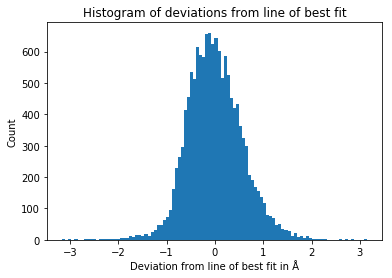

In [24]:
print(len(deviations), min(deviations),max(deviations))
plt.title('Histogram of deviations from line of best fit')
plt.xlabel('Deviation from line of best fit in Å')
plt.ylabel('Count')

plt.hist(deviations, bins = 100)



[Text(0, 0.5, 'deviation'),
 Text(0.5, 0, 'ML AA distance'),
 Text(0.5, 1.0, 'some title')]

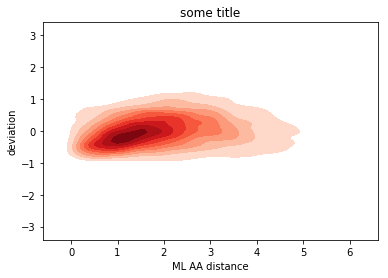

In [53]:
import seaborn as sns
ax = sns.kdeplot(ML_dists, deviations,
cmap="Reds", shade=True, shade_lowest=False)
ax.set(xlabel='ML AA distance', ylabel='deviation', title='some title')


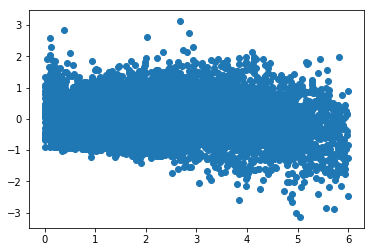

In [45]:
plt.scatter(ML_dists, deviations)

[Text(0, 0.5, 'deviation'), Text(0.5, 0, 'rmsd'), Text(0.5, 1.0, 'some title')]

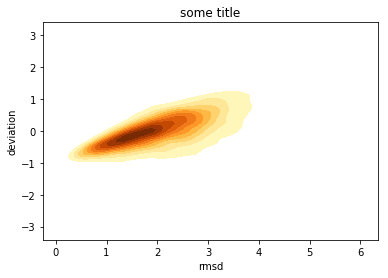

In [52]:
ax = sns.kdeplot(rmsd_dists, deviations,
cmap="YlOrBr", shade=True, shade_lowest=False)
ax.set(xlabel='rmsd', ylabel='deviation', title='some title')

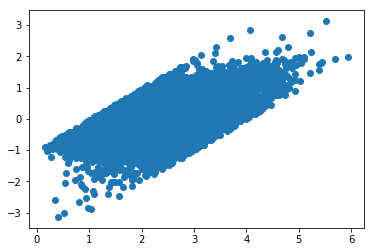

In [46]:
plt.scatter(rmsd_dists, deviations)

(array([ 47.,  43., 135., 142., 128., 133., 144., 143., 166., 178., 191.,
        198., 232., 229., 242., 257., 231., 283., 265., 281., 263., 245.,
        274., 273., 257., 277., 255., 260., 253., 282., 250., 252., 240.,
        262., 234., 249., 244., 241., 207., 229., 209., 192., 198., 174.,
        183., 189., 167., 144., 147., 165., 156., 181., 140., 138., 122.,
        114., 120., 116., 114., 110.,  97., 116.,  90.,  79.,  77.,  80.,
         77.,  64.,  71.,  64.,  75.,  57.,  73.,  54.,  61.,  65.,  42.,
         47.,  39.,  45.,  43.,  41.,  51.,  37.,  31.,  32.,  24.,  38.,
         27.,  21.,  32.,  21.,  23.,  35.,  22.,  12.,  27.,  22.,  23.,
         13.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ,
        0.66, 0.72, 0.78, 0.84, 0.9 , 0.96, 1.02, 1.08, 1.14, 1.2 , 1.26,
        1.32, 1.38, 1.44, 1.5 , 1.56, 1.62, 1.68, 1.74, 1.8 , 1.86, 1.92,
        1.98, 2.04, 2.1 , 2.16, 2.22, 2.28, 2.34, 2.4 , 2.46, 2.52, 2.58,
        2.64, 2.7 , 2.

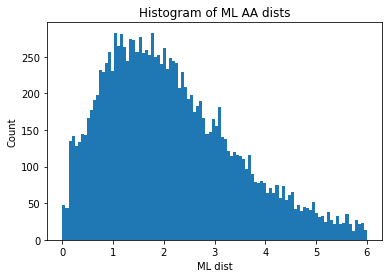

In [42]:
plt.title('Histogram of ML AA dists')
plt.xlabel('ML dist')
plt.ylabel('Count')

plt.hist(ML_dists, bins = 100)


In [10]:
import pdb

def read_labels(tsv_file):
        '''Read tsv file format containing: uid1 \t uid2 \t ML distance \t RMSD distance
        '''

        distance_dict = {} #Save information for each uid pair
        
        with open(tsv_file) as file:
                for line in file:
                        line = line.rstrip() #Remove newlines
                        line = line.split("\t") #Split on tab
                        uid_pair = (line[0]+'_'+line[1]) #Get uid pair
                     
                        
                        ML_dist = float(line[2]) #aa evolutionary distance from tree-puzzle
                        rmsd_dist = float(line[3]) #rmsd from TMalign
                        Chain1 = int(line[4]) 
                        Chain2 = int(line[5])
                        Aligned = int(line[6])/min(Chain1, Chain2)
                        Identity = float(line[7])
                        

                        distance_dict[uid_pair] = [ML_dist, rmsd_dist, Chain1, Chain2, Aligned, Identity]
                        
                                

        return(distance_dict)
    
(distance_dict) = read_labels('/home/pbryant/results/CATH/20190430/all_dist_rmsd.tsv')

def get_locations(encode_locations):
        '''Get all file locations for encodings
        '''

        locations = []
        with open(encode_locations) as file:
                for line in file:
                        line = line.rstrip()
                        locations.append(line)
                       



        return locations

#Get file locations
locations = get_locations('/home/pbryant/results/CATH/20190430/encoding_locations.txt')

#Save H-groups
H_groups = {} 

for file_name in locations:
  
  file_name = file_name.split('/')
  H_group = file_name[-2]
  uid_pair = file_name[-1].split('.')[0]

  H_groups[uid_pair] = H_group



                              
#Match H-group to rmsd and ML aa dist
uids = [] #save uids
H_group_list = []
rmsd_dists = []
ML_dists = []   
                              
for key in locations:
    key = key.split('/')[-1].split('.')[0]
    [ML_dist, rmsd_dist, Chain1, Chain2, Aligned, Identity] = distance_dict[key]
    
    if ML_dist <= 6:
        uids.append(key)
        rmsd_dists.append(rmsd_dist)
        ML_dists.append(ML_dist)
        H_group_list.append(H_groups[key])


In [12]:
print(len(H_group_list), len(rmsd_dists))


13488 13488


In [70]:
#Get deviations from line of best fit
from scipy import stats
deviations = [] #Save deviations
#Calculate line of best fit
(slope, intercept, r_value, p_value, std_err) = stats.linregress(ML_dists, rmsd_dists)
for i in range(0, len(ML_dists)):
    deviation = rmsd_dists[i]-(intercept+slope*ML_dists[i])
    deviations.append(deviation)
    
#Group deviations and uids by H-group
deviation_dict = {} #Save devitaions by H-group
uids_by_group = {} #Save uids by H-group

for i in range(0, len(H_group_list)):
    if H_group_list[i] in deviation_dict.keys():
        deviation_dict[H_group_list[i]].append(deviations[i])
        uids_by_group[H_group_list[i]].append(uids[i]) 
    else:
        deviation_dict[H_group_list[i]] = [deviations[i]]
        uids_by_group[H_group_list[i]] = [uids[i]]
        
    
    


In [71]:
averages = []
abs_averages = []
unique_groups = []
for key in deviation_dict:
    unique_groups.append(key)
    averages.append(sum(deviation_dict[key])/len(deviation_dict[key]))
    
    abs_averages.append(sum([abs(x) for x in deviation_dict[key]])/len(deviation_dict[key]))
    



In [73]:
len(uids_by_group.keys())

2442

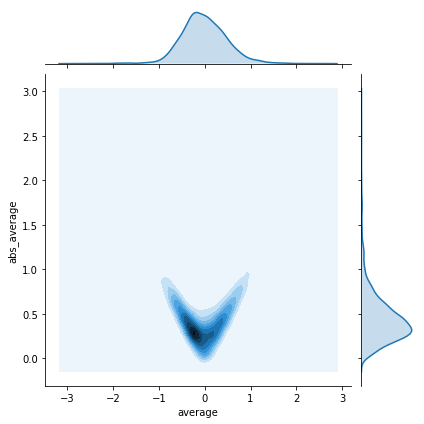

In [152]:
import seaborn as sns
import pandas as pd 
df = pd.DataFrame(list(zip(averages, abs_averages)), 
               columns =['average', 'abs_average']) 
df
sns.jointplot(x="average", y="abs_average", data=df, kind="kde")

In [96]:
#Group by C.A
ca_av_dict = {}
ca_av_abs_dict = {}
for i in range(0, len(unique_groups)):
    CA = unique_groups[i].split('.')[0:2] 
    CA = CA[0]+'.'+CA[1]
    
    if CA in ca_av_dict.keys():
        ca_av_dict[CA].append(averages[i])
        ca_av_abs_dict[CA].append(abs_averages[i])
    else:
        ca_av_dict[CA] = [averages[i]]
        ca_av_abs_dict[CA] = [abs_averages[i]]
    



In [128]:
lst1 = [*ca_av_dict.keys()]
lst2 =[*ca_av_dict.values()]


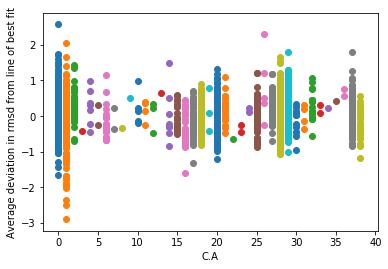

In [135]:
x = []
y = []
c = -1
plt.xlabel('C.A')
plt.ylabel('Average deviation in rmsd from line of best fit')
for item in lst2:
    c+=1
    index = np.zeros(len(item))
    index[0:] += c
    [x.append(i) for i in index]
    [y.append(j) for j in item]
    plt.scatter(index,item)
    
    

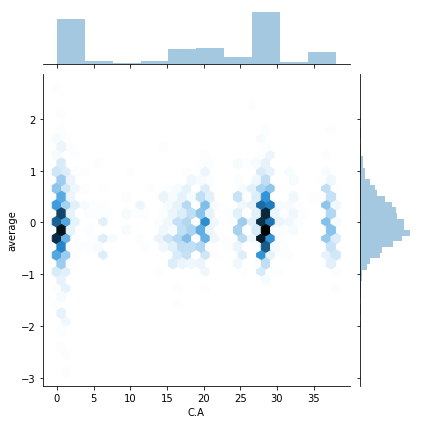

In [147]:
df = pd.DataFrame(list(zip(x, y)), 
               columns =['C.A', 'average']) 

sns.jointplot(x="C.A", y="average", data=df, kind = "hex")

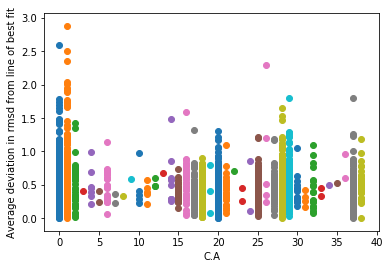

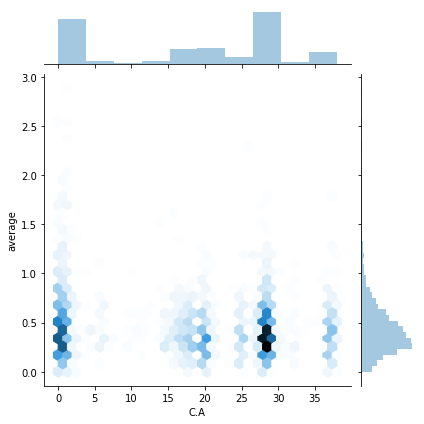

In [156]:
lst1 = [*ca_av_abs_dict.keys()]
lst2 =[*ca_av_abs_dict.values()]
x = []
y = []
c = -1
plt.xlabel('C.A')
plt.ylabel('Average deviation in rmsd from line of best fit')
for item in lst2:
    c+=1
    index = np.zeros(len(item))
    index[0:] += c
    [x.append(i) for i in index]
    [y.append(j) for j in item]
    plt.scatter(index,item)#/home/pbryant/data/CATH/cath-domain-seqs-S95.fa
df = pd.DataFrame(list(zip(x, y)), 
               columns =['C.A', 'average']) 

sns.jointplot(x="C.A", y="average", data=df, kind = "hex")